# Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import nagisa
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

## Read in and process data

In [2]:
wiki_df = pd.read_pickle('wiki') 
wiki_df.head()

,article,views,text
0,メインページ,362562853,ようこそ\nウィキペディア - ウィキペディア日本語版 - 百科事典目次\n検索資料・ポータ...
1,星野源,10190763,星野 源（ほしの みなもと、1981年1月28日 - ）は、日本の音楽家、俳優、文筆家。埼玉...
2,真田信繁,9602104,真田 信繁（さなだ のぶしげ）は、安土桃山時代から江戸時代初期にかけての武将、大名。真田昌幸...
3,高橋一生,8571666,高橋 一生（たかはし いっせい、英字表記：Issey Takahashi、1980年12月9...
4,君の名は。,7788879,『君の名は。』（きみのなは、英: Your Name.）は、2016年に公開された新海誠監督...


In [3]:
data = np.array(wiki_df['text'])

# Text features using Japanese grammar


は   wa   topic     (after)
が   ga   nontopic  (after)
を   o    object    (after)
する suru verb      (after)
る   ru   verb      (after)
な   na   adjective (after)
い   i    adjective (after)
の   no   adj or loc(before)

distance of each of the above

start of a sentence
end of a sentence

In [ ]:
# Create a dataframe of the above metrics (distance from grammatical indicators, location in sentence, etc.)
article_num = 0
features = []
for article in data[0:1000]:
    sentence_num = 0
    for sentence in re.split('\n|。', article):
        cleaned = re.sub('['+'|'.join(list(string.printable))+']','',sentence)
        for i in range(len(cleaned)):
            wa = cleaned[i:].find('は')
            ga = cleaned[i:].find('が')
            o = cleaned[i:].find('を')
            suru = cleaned[i:].find('する')
            ru = cleaned[i:].find('る')
            na = cleaned[i:].find('な')
            ii = cleaned[i:].find('い')
            no = cleaned[(len(cleaned)-i)::-1].find('の')
            if i==0: 
                start_of_sentence = 1
            else:
                start_of_sentence = 0
            if i==len(cleaned):
                end_of_sentence = 1
            else:
                end_of_sentence = 0
            char_data = [cleaned[i], article_num, sentence_num, wa, ga, o, suru, ru, na, ii, no, start_of_sentence, end_of_sentence]
            features.append(char_data)
        sentence_num += 1
    article_num += 1

In [ ]:
df = pd.DataFrame(features)

In [ ]:
df.columns = ['character','articleNumber','sentenceNumber','wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']

In [ ]:
df.to_pickle('grammarfeatures.pkl')

In [4]:
df = pd.read_pickle('grammarfeatures.pkl')

In [5]:
df

,character,articleNumber,sentenceNumber,wa,ga,o,suru,ru,na,ii,no,startSentence,endSentence
0,よ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,1,0
1,う,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
2,こ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
3,そ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
4,ウ,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16397896,月,999,122,-1,-1,-1,-1,-1,-1,-1,-1,0,0
16397897,日,999,122,-1,-1,-1,-1,-1,-1,-1,-1,0,0
16397898,森,999,123,-1,-1,-1,-1,-1,-1,-1,-1,1,0
16397899,泉,999,123,-1,-1,-1,-1,-1,-1,-1,-1,0,0


## K-means Clustering

In [8]:
kmeans = KMeans(init="k-means++", n_clusters=5)
kmeans.fit(df[['wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']])

KMeans(n_clusters=5)

In [9]:
labels = kmeans.predict(df[['wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']])

In [10]:
for label in range(0,5):
    print("Label: " + str(label))
    label_indices = [i for i in range(len(labels)) if labels[i]==label]
    matching_chars = []
    for i in label_indices:
        if i < 100:
            matching_chars.append(df['character'].iloc[i])
        else: break
    print(matching_chars)
    print("\n")

Label: 0
['よ', 'う', 'こ', 'そ', 'ウ', 'ィ', 'キ', 'ペ', 'デ', 'ィ', 'ア', '-', 'ウ', 'ィ', 'キ', 'ペ', 'デ', 'ィ', 'ア', '日', '本', '語', '版', '-', '百', '科', '事', '典', '目', '次', '検', '索', '資', '料', '・', 'ポ', 'ー', 'タ', 'ル', '・', 'カ', 'テ', 'ゴ', 'リ', '秀', '逸', 'ピ', 'ッ', 'ク', 'ア', 'ッ', 'プ', '-', '他', 'の', '秀', '逸', '記', '事', 'つ', 'ま', 'み', '読', 'み', '選', '考', '新', 'し', 'い', '記', '事', '-', '投', '票', '新', '着', '新', 'し', 'い', '画', '像', '-', '投', '票', '新', '着', '今', '日', 'は', '何', 'の', '日', '-', 'こ', 'よ', 'み', '-', '季', '節', 'の']


Label: 1
[]


Label: 2
[]


Label: 3
[]


Label: 4
[]




## Random Tree Embedding followed by Truncated SVD and K-Means

In [11]:
# Use first 100 observations
rt = RandomTreesEmbedding().fit(df[['wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']].iloc[0:100])

In [12]:
# Sample decision path
rt.decision_path(df[['wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']].iloc[0:1])

(<1x2206 sparse matrix of type '<class 'numpy.int64'>'
 	with 532 stored elements in Compressed Sparse Row format>,
 array([   0,   21,   46,   69,  102,  119,  138,  155,  180,  209,  236,
         259,  286,  309,  336,  359,  382,  397,  416,  443,  468,  481,
         506,  527,  550,  569,  592,  611,  634,  649,  676,  703,  726,
         743,  768,  785,  804,  825,  844,  871,  898,  915,  934,  965,
         982,  999, 1026, 1045, 1066, 1095, 1120, 1139, 1158, 1179, 1204,
        1223, 1242, 1259, 1280, 1305, 1332, 1357, 1380, 1409, 1426, 1445,
        1462, 1481, 1498, 1519, 1538, 1559, 1574, 1597, 1620, 1639, 1658,
        1683, 1710, 1725, 1744, 1763, 1788, 1809, 1836, 1851, 1874, 1887,
        1906, 1927, 1962, 1985, 2012, 2039, 2062, 2081, 2112, 2133, 2160,
        2183, 2206], dtype=int32))

In [13]:
# Create pipeline
rt_embedding = make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=5))

In [32]:
df

,character,articleNumber,sentenceNumber,wa,ga,o,suru,ru,na,ii,no,startSentence,endSentence
0,よ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,1,0
1,う,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
2,こ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
3,そ,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0
4,ウ,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16397896,月,999,122,-1,-1,-1,-1,-1,-1,-1,-1,0,0
16397897,日,999,122,-1,-1,-1,-1,-1,-1,-1,-1,0,0
16397898,森,999,123,-1,-1,-1,-1,-1,-1,-1,-1,1,0
16397899,泉,999,123,-1,-1,-1,-1,-1,-1,-1,-1,0,0


In [33]:
# Fit and transform data (first 50,000)
transformed = rt_embedding.fit_transform(df[['wa','ga','o','suru','ru','na','ii','no','startSentence','endSentence']].iloc[0:50000])

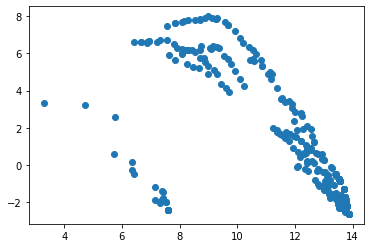

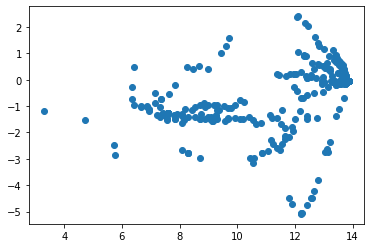

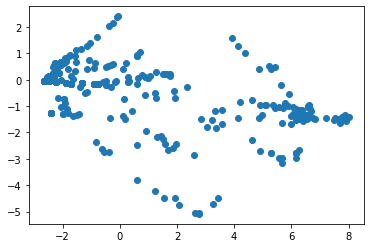

In [35]:
# Plot sample new data points
x = [transformed[i][0] for i in range(500)]
y = [transformed[i][1] for i in range(500)]
z = [transformed[i][2] for i in range(500)]
plt.scatter(x,y)
plt.show()
plt.scatter(x,z)
plt.show()
plt.scatter(y,z)
plt.show()

In [ ]:
# K-means clustering

In [36]:
kmeans = KMeans(init="k-means++", n_clusters=13)
kmeans.fit(transformed)

KMeans(n_clusters=13)

In [ ]:
# Compare output labels to nagisa

In [37]:
labels = []
for i in range(len(transformed)):
    labels.append(kmeans.predict(transformed[i].reshape(1, -1))[0])

In [38]:
print(labels[0:50])

[10, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 8, 8, 8, 8, 8, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [19]:
test = nagisa.tagging(data[0])
print(test.words, test.postags)

['よう', 'こそ', '\n', 'ウィキペディア', '\u3000', '-', '\u3000', 'ウィキペディア', '日本', '語', '版', '\u3000', '-', '\u3000', '百', '科', '事典', '目次', '\n', '検索', '資料', '・', 'ポータル', '・', 'カテゴリ', '秀逸', 'ピックアップ', '\u3000', '-', '\u3000', '他', 'の', '秀逸', '記事', '/', 'つまみ', '読み', '/', '選考', '\n', '新しい', '記事', '\u3000', '-', '\u3000', '投票', '/', '新着', '\n', '新しい', '画像', '\u3000', '-', '\u3000', '投票', '/', '新着', '\n', '今日', 'は', '何', 'の', '日', '\u3000', '-', '\u3000', 'こよみ', '\u3000', '-', '\u3000', '季節', 'の', '話題', '\n', '季節', 'の', '画像', '\u3000', '-', '\u3000', '投票', 'ガイド', '\n', '閲覧', '方法', '\u3000', '-', '\u3000', '参加', '方法', '\u3000', '-', '\u3000', '引用', '方法', '\n', 'ヘルプ', '\u3000', '-', '\u3000', 'FAQ', '\n', 'ウィキペディア', 'に', '関する', 'お', '問い合わせ', '先', '\n', 'プレスルーム', 'お', '知ら', 'せ', '\n', 'コミュニティ', '・', 'ポータル', '\n', '井戸', '端', '\u3000', '(', '告知', ')', '\u3000', '-', '\u3000', '井戸', '端', '\n', '記事', 'と', 'は', '\n', 'アクセス', '統計', '\u3000', '-', '\u3000', '日本', '語', '版', 'の', '統計', '\n', 'For', '\u3000', 'non

In [ ]:
# Output comparison

# Original word
['よう', 'こそ', '\n', 'ウィキペディア', '\u3000', '-', '\u3000', 'ウィキペディア', '日本', '語', '版', '\u3000', '-', '\u3000', '百', '科', '事典', '目次', '\n', '検索', '資料', '・', 'ポータル', '・', 'カテゴリ', '秀逸', 'ピックアップ', '\u3000', '-', '\u3000', '他', 'の', '秀逸', '記事', '/', 'つまみ', '読み', '/', '選考', '\n', '新しい', '記事', '\u3000', '-', '\u3000', '投票', '/', '新着', '\n', '新しい', '画像', '\u3000', '-', '\u3000', '投票', '/', '新着', '\n', '今日', 'は', '何', 'の', '日', '\u3000', '-', '\u3000', 'こよみ', '\u3000', '-', '\u3000', '季節', 'の', '話題', '\n', '季節', 'の', '画像', '\u3000', '-', '\u3000', '投票', 'ガイド', '\n', '閲覧', '方法', '\u3000', '-', '\u3000', '参加', '方法', '\u3000', '-', '\u3000', '引用', '方法', '\n', 'ヘルプ', '\u3000', '-', '\u3000', 'FAQ', '\n', 'ウィキペディア', 'に', '関する', 'お', '問い合わせ', '先', '\n', 'プレスルーム', 'お', '知ら', 'せ', '\n', 'コミュニティ', '・', 'ポータル', '\n', '井戸', '端', '\u3000', '(', '告知', ')', '\u3000', '-', '\u3000', '井戸', '端', '\n', '記事', 'と', 'は', '\n', 'アクセス', '統計', '\u3000', '-', '\u3000', '日本', '語', '版', 'の', '統計', '\n', 'For', '\u3000', 'non', '-', 'Japanese', '-', 'speakers', '\u3000', '-', '\u3000', 'Main', '\u3000', 'Page', '\u3000', 'for', '\u3000', 'Japanese', '-', 'learners', '方針', '\n', '五', '本', 'の', '柱', '\n', '著作', '権', 'の', '扱い', '\n', '免責', '事項', 'ウィキメディア', '\n', 'ウィキメディア', 'の', 'プロジェクト', '色々', 'な', 'メイン', 'ページ', '形式', '\u3000', '-', '\u3000', '携帯', '版', 'メイン', 'ページ']

# Nagisa label
['形容詞', '助詞', '補助記号', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '接尾辞', '名詞', '名詞', '補助記号', '名詞', '名詞', '補助記号', '名詞', '補助記号', '名詞', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '助詞', '名詞', '名詞', '補助記号', '名詞', '名詞', '補助記号', '名詞', '補助記号', '形容詞', '名詞', '空白', '補助記号', '空白', '名詞', '補助記号', '名詞', '補助記号', '形容詞', '名詞', '空白', '補助記号', '空白', '名詞', '補助記号', '名詞', '補助記号', '名詞', '助詞', '代名詞', '助詞', '名詞', '空白', '補助記号', '空白', '名詞', '空白', '補助記号', '空白', '名詞', '助詞', '名詞', '補助記号', '名詞', '助詞', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '補助記号', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '補助記号', '名詞', '空白', '補助記号', '空白', '名詞', '補助記号', '名詞', '助詞', '動詞', '接頭辞', '動詞', '名詞', '補助記号', '名詞', '接頭辞', '動詞', '助動詞', '補助記号', '名詞', '補助記号', '名詞', '補助記号', '名詞', '名詞', '空白', '補助記号', '名詞', '補助記号', '空白', '補助記号', '空白', '名詞', '名詞', '補助記号', '名詞', '助詞', '助詞', '記号', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '名詞', '助詞', '名詞', '補助記号', '英単語', '空白', '英単語', '補助記号', '英単語', '補助記号', '英単語', '空白', '補助記号', '空白', '英単語', '空白', '英単語', '空白', '英単語', '空白', '英単語', '補助記号', '記号', '名詞', '記号', '名詞', '接尾辞', '助詞', '名詞', '補助記号', '名詞', '接尾辞', '助詞', '名詞', '補助記号', '名詞', '名詞', '名詞', '補助記号', '名詞', '助詞', '名詞', '形状詞', '助動詞', '名詞', '名詞', '名詞', '空白', '補助記号', '空白', '名詞', '名詞', '名詞', '名詞']

# Label from this method
[2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 4, 4, 4, 12, 1, 7, 7, 7, 5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 3, 11, 0, 0, 0, 0, 0, 0, 0, 10, 3, 11, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 8, 4, 4, 12, 1, 7, 7, 7, 5, 8, 0]